In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, 1000)

/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
hm_detection_thresholds = [.01, .05, .1, .2, .4]
pp_conflict_overlaps = [.2, .4, .6, .8]
ms_radius = [10, 20, 40, 50, 70, 90, 110]
ms_between_distances = [10, 30, 50, 60, 70, 90, 110, 150]
min_joint_distances = [0, 20, 40, 50, 70, 100, 150]

# TOTAL = len(hm_detection_thresholds) \
#     * len(pp_conflict_overlaps)\
#     * len(ms_radius)\
#     * len(ms_between_distances)\
#     * len(min_joint_distances)

# TOTAL = len(ms_radius) * len(ms_between_distances)

#print('combinations:', TOTAL)


loader = Loader()

def generate_pcp_score(frame, params):
    global loader, gen
    alpha = 0.5
    
    Im, Y, Calib = epfl_campus.get(root, frame)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'campus', Im, frame, dir=Settings['tmp'])
    detections = pose.estimate(Calib, heatmaps, pafs, 
                               settings=params, debug=False)
    #detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    del heatmaps
    del pafs
    del detections
    del Im
    del Y
    del Calib
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

# ======================================
# RUN
# ======================================

ms_radius = [10, 20, 30, 40, 50, 60, 70, 90, 110, 120, 130, 140]
ms_between_distances = [10, 30, 50, 60, 70, 90, 110, 120, 130, 150]
TESTS = []


for radius in ms_radius:
    for between_distance in ms_between_distances:
        
        _START = time()
        print('\n--- next step ---')
        print('radius:', radius)
        print('between_distance:', between_distance)
        
        valid_frames = list(range(350, 470, 5)) + list(range(650, 750, 5))
        params = get_settings(scale_to_mm=1000,
                          hm_detection_threshold=0.05,
                          pp_conflict_overlap=0.4,
                          ms_radius=radius,
                          ms_between_distance=between_distance)
        
        
        PER_GTID = {}
        TESTS.append(PER_GTID)
        for frame in valid_frames:
            _start = time()
            L_Arms, U_Arms, L_Legs, U_Legs, GTIDs =\
                generate_pcp_score(frame, params)
            _end = time()
            print('frame ' + str(frame) + ', elapsed:', _end - _start)
            if len(L_Arms) > 0:
                for gtid, larms, uarms, llegs, ulegs in zip(
                    GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
                ):
                    if not gtid in PER_GTID:
                        PER_GTID[gtid] = {
                            'larms': [],
                            'uarms': [],
                            'llegs': [],
                            'ulegs': [],
                            'frame': []
                        }
                    PER_GTID[gtid]['larms'].append(larms)
                    PER_GTID[gtid]['uarms'].append(uarms)
                    PER_GTID[gtid]['llegs'].append(llegs)
                    PER_GTID[gtid]['ulegs'].append(ulegs)
                    PER_GTID[gtid]['frame'].append(frame)
                    #AVG.append((larms + uarms + llegs + ulegs)/4)
        _END = time()
        print('total step ELAPSED:', _END - _START)




--- next step ---
radius: 10
between_distance: 10
frame 350, elapsed: 0.348097562789917
frame 355, elapsed: 0.32952880859375
frame 360, elapsed: 0.34186649322509766
frame 365, elapsed: 0.30907773971557617
frame 370, elapsed: 0.3237910270690918
frame 375, elapsed: 0.3045356273651123
frame 380, elapsed: 0.32759857177734375
frame 385, elapsed: 0.32433581352233887
frame 390, elapsed: 0.32004404067993164
frame 395, elapsed: 0.4424865245819092
frame 400, elapsed: 0.4577767848968506
frame 405, elapsed: 0.42165040969848633
frame 410, elapsed: 0.5879175662994385
frame 415, elapsed: 0.42427611351013184
frame 420, elapsed: 0.40201568603515625
frame 425, elapsed: 0.4107050895690918
frame 430, elapsed: 0.501532793045044
frame 435, elapsed: 0.54433274269104
frame 440, elapsed: 0.5417249202728271
frame 445, elapsed: 0.3134143352508545
frame 450, elapsed: 0.5652356147766113
frame 455, elapsed: 0.3387446403503418
frame 460, elapsed: 0.3466064929962158
frame 465, elapsed: 0.3943772315979004
frame 650, 

frame 465, elapsed: 0.3402726650238037
frame 650, elapsed: 0.34072232246398926
frame 655, elapsed: 0.3319568634033203
frame 660, elapsed: 0.3623616695404053
frame 665, elapsed: 0.3732881546020508
frame 670, elapsed: 0.4153473377227783
frame 675, elapsed: 0.36572742462158203
frame 680, elapsed: 0.5009548664093018
frame 685, elapsed: 0.49004149436950684
frame 690, elapsed: 0.42354440689086914
frame 695, elapsed: 0.7102992534637451
frame 700, elapsed: 0.8202636241912842
frame 705, elapsed: 1.0218877792358398
frame 710, elapsed: 0.823796272277832
frame 715, elapsed: 0.7780055999755859
frame 720, elapsed: 0.7099690437316895
frame 725, elapsed: 0.7688508033752441
frame 730, elapsed: 0.9101049900054932
frame 735, elapsed: 1.0225584506988525
frame 740, elapsed: 1.2351486682891846
frame 745, elapsed: 0.9249217510223389
total step ELAPSED: 21.092058420181274

--- next step ---
radius: 10
between_distance: 90
frame 350, elapsed: 0.29606151580810547
frame 355, elapsed: 0.2961890697479248
frame 360

frame 355, elapsed: 0.2949244976043701
frame 360, elapsed: 0.2981586456298828
frame 365, elapsed: 0.29094481468200684
frame 370, elapsed: 0.2755107879638672
frame 375, elapsed: 0.2689218521118164
frame 380, elapsed: 0.28396034240722656
frame 385, elapsed: 0.2802867889404297
frame 390, elapsed: 0.27460360527038574
frame 395, elapsed: 0.296489953994751
frame 400, elapsed: 0.3086972236633301
frame 405, elapsed: 0.3031129837036133
frame 410, elapsed: 0.32063794136047363
frame 415, elapsed: 0.3146176338195801
frame 420, elapsed: 0.2904469966888428
frame 425, elapsed: 0.30693578720092773
frame 430, elapsed: 0.29786062240600586
frame 435, elapsed: 0.3439490795135498
frame 440, elapsed: 0.32328295707702637
frame 445, elapsed: 0.28492188453674316
frame 450, elapsed: 0.3026430606842041
frame 455, elapsed: 0.33528995513916016
frame 460, elapsed: 0.29279398918151855
frame 465, elapsed: 0.3001878261566162
frame 650, elapsed: 0.3027303218841553
frame 655, elapsed: 0.30114173889160156
frame 660, elap

frame 655, elapsed: 0.3240363597869873
frame 660, elapsed: 0.34486961364746094
frame 665, elapsed: 0.36580991744995117
frame 670, elapsed: 0.4004180431365967
frame 675, elapsed: 0.35105276107788086
frame 680, elapsed: 0.4495584964752197
frame 685, elapsed: 0.4754822254180908
frame 690, elapsed: 0.4024343490600586
frame 695, elapsed: 0.5898759365081787
frame 700, elapsed: 0.7979745864868164
frame 705, elapsed: 0.9155147075653076
frame 710, elapsed: 0.7272152900695801
frame 715, elapsed: 0.7631399631500244
frame 720, elapsed: 0.7587573528289795
frame 725, elapsed: 0.6853809356689453
frame 730, elapsed: 0.8978931903839111
frame 735, elapsed: 1.1902046203613281
frame 740, elapsed: 0.9703037738800049
frame 745, elapsed: 0.9374306201934814
total step ELAPSED: 20.481247425079346

--- next step ---
radius: 20
between_distance: 70
frame 350, elapsed: 0.30538010597229004
frame 355, elapsed: 0.31213903427124023
frame 360, elapsed: 0.38169240951538086
frame 365, elapsed: 0.2962913513183594
frame 3

frame 365, elapsed: 0.2948949337005615
frame 370, elapsed: 0.2924213409423828
frame 375, elapsed: 0.29041218757629395
frame 380, elapsed: 0.2893350124359131
frame 385, elapsed: 0.29320693016052246
frame 390, elapsed: 0.2864241600036621
frame 395, elapsed: 0.3050534725189209
frame 400, elapsed: 0.3239574432373047
frame 405, elapsed: 0.3325228691101074
frame 410, elapsed: 0.33599138259887695
frame 415, elapsed: 0.3426079750061035
frame 420, elapsed: 0.31303954124450684
frame 425, elapsed: 0.34108877182006836
frame 430, elapsed: 0.34513425827026367
frame 435, elapsed: 0.38272643089294434
frame 440, elapsed: 0.41761183738708496
frame 445, elapsed: 0.32932233810424805
frame 450, elapsed: 0.30966734886169434
frame 455, elapsed: 0.27368783950805664
frame 460, elapsed: 0.2932143211364746
frame 465, elapsed: 0.29932141304016113
frame 650, elapsed: 0.29378485679626465
frame 655, elapsed: 0.29297471046447754
frame 660, elapsed: 0.30861568450927734
frame 665, elapsed: 0.3078629970550537
frame 670,

frame 665, elapsed: 0.37346696853637695
frame 670, elapsed: 0.46396899223327637
frame 675, elapsed: 0.34830141067504883
frame 680, elapsed: 0.45573997497558594
frame 685, elapsed: 0.4697227478027344
frame 690, elapsed: 0.4126861095428467
frame 695, elapsed: 0.5786151885986328
frame 700, elapsed: 1.0095384120941162
frame 705, elapsed: 0.8769407272338867
frame 710, elapsed: 0.799156904220581
frame 715, elapsed: 0.746631383895874
frame 720, elapsed: 0.994279146194458
frame 725, elapsed: 0.7755975723266602
frame 730, elapsed: 1.030702829360962
frame 735, elapsed: 1.1571707725524902
frame 740, elapsed: 1.08778977394104
frame 745, elapsed: 0.897735595703125
total step ELAPSED: 21.581528186798096

--- next step ---
radius: 30
between_distance: 60
frame 350, elapsed: 0.2956061363220215
frame 355, elapsed: 0.3167586326599121
frame 360, elapsed: 0.31229567527770996
frame 365, elapsed: 0.2994966506958008
frame 370, elapsed: 0.3007981777191162
frame 375, elapsed: 0.28771543502807617
frame 380, ela

frame 375, elapsed: 0.2652750015258789
frame 380, elapsed: 0.27985239028930664
frame 385, elapsed: 0.277285099029541
frame 390, elapsed: 0.27315831184387207
frame 395, elapsed: 0.29790282249450684
frame 400, elapsed: 0.32216405868530273
frame 405, elapsed: 0.3083949089050293
frame 410, elapsed: 0.331695556640625
frame 415, elapsed: 0.33199381828308105
frame 420, elapsed: 0.29822278022766113
frame 425, elapsed: 0.3135538101196289
frame 430, elapsed: 0.3169412612915039
frame 435, elapsed: 0.34856152534484863
frame 440, elapsed: 0.34514307975769043
frame 445, elapsed: 0.2883450984954834
frame 450, elapsed: 0.3139626979827881
frame 455, elapsed: 0.2733726501464844
frame 460, elapsed: 0.29406046867370605
frame 465, elapsed: 0.30138516426086426
frame 650, elapsed: 0.3003218173980713
frame 655, elapsed: 0.289966344833374
frame 660, elapsed: 0.3113832473754883
frame 665, elapsed: 0.31245851516723633
frame 670, elapsed: 0.34398841857910156
frame 675, elapsed: 0.31600332260131836
frame 680, elap

frame 675, elapsed: 0.38880300521850586
frame 680, elapsed: 0.48409056663513184
frame 685, elapsed: 0.528418779373169
frame 690, elapsed: 0.7129433155059814
frame 695, elapsed: 1.2287781238555908
frame 700, elapsed: 2.0820484161376953
frame 705, elapsed: 1.3915321826934814
frame 710, elapsed: 1.191964864730835
frame 715, elapsed: 1.2402160167694092
frame 720, elapsed: 1.0032696723937988
frame 725, elapsed: 1.2471983432769775
frame 730, elapsed: 1.2210822105407715
frame 735, elapsed: 1.6921288967132568
frame 740, elapsed: 1.316222906112671
frame 745, elapsed: 1.1957166194915771
total step ELAPSED: 27.239940643310547

--- next step ---
radius: 40
between_distance: 50
frame 350, elapsed: 0.3127613067626953
frame 355, elapsed: 0.30872225761413574
frame 360, elapsed: 0.30695509910583496
frame 365, elapsed: 0.3505580425262451
frame 370, elapsed: 0.2955605983734131
frame 375, elapsed: 0.28104233741760254
frame 380, elapsed: 0.2987098693847656
frame 385, elapsed: 0.30409693717956543
frame 390,

frame 385, elapsed: 0.28481006622314453
frame 390, elapsed: 0.2737102508544922
frame 395, elapsed: 0.298614501953125
frame 400, elapsed: 0.32354259490966797
frame 405, elapsed: 0.3225901126861572
frame 410, elapsed: 0.34823155403137207
frame 415, elapsed: 0.33447813987731934
frame 420, elapsed: 0.30797672271728516
frame 425, elapsed: 0.3222692012786865
frame 430, elapsed: 0.3173024654388428
frame 435, elapsed: 0.3615853786468506
frame 440, elapsed: 0.3375828266143799
frame 445, elapsed: 0.28834056854248047
frame 450, elapsed: 0.32587146759033203
frame 455, elapsed: 0.27355527877807617
frame 460, elapsed: 0.3037116527557373
frame 465, elapsed: 0.30421972274780273
frame 650, elapsed: 0.303255558013916
frame 655, elapsed: 0.3024165630340576
frame 660, elapsed: 0.3313286304473877
frame 665, elapsed: 0.3781924247741699
frame 670, elapsed: 0.360370397567749
frame 675, elapsed: 0.32924628257751465
frame 680, elapsed: 0.3928241729736328
frame 685, elapsed: 0.4140138626098633
frame 690, elapsed

frame 685, elapsed: 0.4788079261779785
frame 690, elapsed: 0.41295313835144043
frame 695, elapsed: 0.582155704498291
frame 700, elapsed: 1.0295753479003906
frame 705, elapsed: 0.8471941947937012
frame 710, elapsed: 0.7891249656677246
frame 715, elapsed: 0.7432467937469482
frame 720, elapsed: 0.8434383869171143
frame 725, elapsed: 0.7461380958557129
frame 730, elapsed: 1.005810260772705
frame 735, elapsed: 1.1714305877685547
frame 740, elapsed: 1.0527617931365967
frame 745, elapsed: 0.6954624652862549
total step ELAPSED: 21.341936349868774

--- next step ---
radius: 50
between_distance: 30
frame 350, elapsed: 0.3005678653717041
frame 355, elapsed: 0.30117130279541016
frame 360, elapsed: 0.29724669456481934
frame 365, elapsed: 0.29631924629211426
frame 370, elapsed: 0.2944214344024658
frame 375, elapsed: 0.27248668670654297
frame 380, elapsed: 0.28656601905822754
frame 385, elapsed: 0.30420994758605957
frame 390, elapsed: 0.28125786781311035
frame 395, elapsed: 0.3579287528991699
frame 4

frame 395, elapsed: 0.36794447898864746
frame 400, elapsed: 0.3330113887786865
frame 405, elapsed: 0.3138003349304199
frame 410, elapsed: 0.3399536609649658
frame 415, elapsed: 0.32846879959106445
frame 420, elapsed: 0.30956363677978516
frame 425, elapsed: 0.3211061954498291
frame 430, elapsed: 0.3201315402984619
frame 435, elapsed: 0.37706661224365234
frame 440, elapsed: 0.3465423583984375
frame 445, elapsed: 0.29077744483947754
frame 450, elapsed: 0.33824706077575684
frame 455, elapsed: 0.2877516746520996
frame 460, elapsed: 0.30042338371276855
frame 465, elapsed: 0.32043027877807617
frame 650, elapsed: 0.3095829486846924
frame 655, elapsed: 0.3037843704223633
frame 660, elapsed: 0.31929683685302734
frame 665, elapsed: 0.34471988677978516
frame 670, elapsed: 0.37338995933532715
frame 675, elapsed: 0.33301448822021484
frame 680, elapsed: 0.41427135467529297
frame 685, elapsed: 0.4770336151123047
frame 690, elapsed: 0.39593005180358887
frame 695, elapsed: 0.5547747611999512
frame 700, 

frame 695, elapsed: 0.4664735794067383
frame 700, elapsed: 0.5347750186920166
frame 705, elapsed: 0.5202803611755371
frame 710, elapsed: 0.5156800746917725
frame 715, elapsed: 0.5011849403381348
frame 720, elapsed: 0.48809194564819336
frame 725, elapsed: 0.5146894454956055
frame 730, elapsed: 0.6858458518981934
frame 735, elapsed: 0.5782325267791748
frame 740, elapsed: 0.5873210430145264
frame 745, elapsed: 0.6893246173858643
total step ELAPSED: 16.365487575531006

--- next step ---
radius: 60
between_distance: 10
frame 350, elapsed: 0.2908213138580322
frame 355, elapsed: 0.2897806167602539
frame 360, elapsed: 0.29485034942626953
frame 365, elapsed: 0.28234076499938965
frame 370, elapsed: 0.2831993103027344
frame 375, elapsed: 0.2719576358795166
frame 380, elapsed: 0.28481459617614746
frame 385, elapsed: 0.2896542549133301
frame 390, elapsed: 0.27878308296203613
frame 395, elapsed: 0.3351585865020752
frame 400, elapsed: 0.3616302013397217
frame 405, elapsed: 0.3343167304992676
frame 41

frame 405, elapsed: 0.3271825313568115
frame 410, elapsed: 0.37700414657592773
frame 415, elapsed: 0.34534382820129395
frame 420, elapsed: 0.3201103210449219
frame 425, elapsed: 0.3378262519836426
frame 430, elapsed: 0.3296027183532715
frame 435, elapsed: 0.39333271980285645
frame 440, elapsed: 0.3836345672607422
frame 445, elapsed: 0.29338717460632324
frame 450, elapsed: 0.3678112030029297
frame 455, elapsed: 0.2923591136932373
frame 460, elapsed: 0.30316972732543945
frame 465, elapsed: 0.3313288688659668
frame 650, elapsed: 0.4041471481323242
frame 655, elapsed: 0.3124969005584717
frame 660, elapsed: 0.3465855121612549
frame 665, elapsed: 0.3543062210083008
frame 670, elapsed: 0.3887355327606201
frame 675, elapsed: 0.34563136100769043
frame 680, elapsed: 0.44270753860473633
frame 685, elapsed: 0.4701991081237793
frame 690, elapsed: 0.4003579616546631
frame 695, elapsed: 0.6262624263763428
frame 700, elapsed: 0.8682165145874023
frame 705, elapsed: 0.8304657936096191
frame 710, elapsed

frame 705, elapsed: 0.6165616512298584
frame 710, elapsed: 0.6149492263793945
frame 715, elapsed: 0.5531888008117676
frame 720, elapsed: 0.5125060081481934
frame 725, elapsed: 0.5669379234313965
frame 730, elapsed: 0.6850948333740234
frame 735, elapsed: 0.676689863204956
frame 740, elapsed: 0.6236677169799805
frame 745, elapsed: 0.6463813781738281
total step ELAPSED: 16.989283323287964

--- next step ---
radius: 60
between_distance: 150
frame 350, elapsed: 0.2872138023376465
frame 355, elapsed: 0.30597424507141113
frame 360, elapsed: 0.3459935188293457
frame 365, elapsed: 0.33094239234924316
frame 370, elapsed: 0.3315150737762451
frame 375, elapsed: 0.32141637802124023
frame 380, elapsed: 0.32525110244750977
frame 385, elapsed: 0.3206479549407959
frame 390, elapsed: 0.3204512596130371
frame 395, elapsed: 0.34900927543640137
frame 400, elapsed: 0.3629899024963379
frame 405, elapsed: 0.3639237880706787
frame 410, elapsed: 0.39159727096557617
frame 415, elapsed: 0.36660122871398926
frame 

frame 415, elapsed: 0.35222339630126953
frame 420, elapsed: 0.32431912422180176
frame 425, elapsed: 0.3352632522583008
frame 430, elapsed: 0.3908045291900635
frame 435, elapsed: 0.388303279876709
frame 440, elapsed: 0.39625000953674316
frame 445, elapsed: 0.2983071804046631
frame 450, elapsed: 0.37791991233825684
frame 455, elapsed: 0.30145692825317383
frame 460, elapsed: 0.3058757781982422
frame 465, elapsed: 0.32762813568115234
frame 650, elapsed: 0.3267199993133545
frame 655, elapsed: 0.32681965827941895
frame 660, elapsed: 0.34569239616394043
frame 665, elapsed: 0.35547828674316406
frame 670, elapsed: 0.39900708198547363
frame 675, elapsed: 0.35273170471191406
frame 680, elapsed: 0.46767616271972656
frame 685, elapsed: 0.5090641975402832
frame 690, elapsed: 0.43187522888183594
frame 695, elapsed: 0.6906285285949707
frame 700, elapsed: 0.8775739669799805
frame 705, elapsed: 1.2498109340667725
frame 710, elapsed: 0.7062928676605225
frame 715, elapsed: 0.8162646293640137
frame 720, el

frame 715, elapsed: 0.6196672916412354
frame 720, elapsed: 0.5381655693054199
frame 725, elapsed: 0.5969970226287842
frame 730, elapsed: 0.6787111759185791
frame 735, elapsed: 0.7758867740631104
frame 740, elapsed: 0.7325105667114258
frame 745, elapsed: 0.7114636898040771
total step ELAPSED: 18.54189157485962

--- next step ---
radius: 70
between_distance: 130
frame 350, elapsed: 0.3030121326446533
frame 355, elapsed: 0.31226086616516113
frame 360, elapsed: 0.3217277526855469
frame 365, elapsed: 0.3131103515625
frame 370, elapsed: 0.3176572322845459
frame 375, elapsed: 0.2823765277862549
frame 380, elapsed: 0.2882964611053467
frame 385, elapsed: 0.3050267696380615
frame 390, elapsed: 0.35841917991638184
frame 395, elapsed: 0.3673844337463379
frame 400, elapsed: 0.32138657569885254
frame 405, elapsed: 0.36893773078918457
frame 410, elapsed: 0.34254956245422363
frame 415, elapsed: 0.32553720474243164
frame 420, elapsed: 0.3078343868255615
frame 425, elapsed: 0.3748753070831299
frame 430,

frame 425, elapsed: 0.3252100944519043
frame 430, elapsed: 0.3225069046020508
frame 435, elapsed: 0.3735663890838623
frame 440, elapsed: 0.3508141040802002
frame 445, elapsed: 0.29125475883483887
frame 450, elapsed: 0.3335423469543457
frame 455, elapsed: 0.28572702407836914
frame 460, elapsed: 0.3025827407836914
frame 465, elapsed: 0.3156731128692627
frame 650, elapsed: 0.3119628429412842
frame 655, elapsed: 0.30762791633605957
frame 660, elapsed: 0.3242354393005371
frame 665, elapsed: 0.3305397033691406
frame 670, elapsed: 0.39283156394958496
frame 675, elapsed: 0.32488179206848145
frame 680, elapsed: 0.4070401191711426
frame 685, elapsed: 0.44191479682922363
frame 690, elapsed: 0.39069223403930664
frame 695, elapsed: 0.5718116760253906
frame 700, elapsed: 0.7354488372802734
frame 705, elapsed: 0.835334300994873
frame 710, elapsed: 0.7526309490203857
frame 715, elapsed: 0.7249469757080078
frame 720, elapsed: 0.6982414722442627
frame 725, elapsed: 0.6398160457611084
frame 730, elapsed:

frame 725, elapsed: 0.5644962787628174
frame 730, elapsed: 0.7735617160797119
frame 735, elapsed: 0.7790932655334473
frame 740, elapsed: 0.8275365829467773
frame 745, elapsed: 0.6773293018341064
total step ELAPSED: 17.774314641952515

--- next step ---
radius: 90
between_distance: 120
frame 350, elapsed: 0.2824079990386963
frame 355, elapsed: 0.28090548515319824
frame 360, elapsed: 0.2931687831878662
frame 365, elapsed: 0.27958011627197266
frame 370, elapsed: 0.27936363220214844
frame 375, elapsed: 0.26947879791259766
frame 380, elapsed: 0.28043365478515625
frame 385, elapsed: 0.2837178707122803
frame 390, elapsed: 0.27501559257507324
frame 395, elapsed: 0.3016934394836426
frame 400, elapsed: 0.3281733989715576
frame 405, elapsed: 0.3198411464691162
frame 410, elapsed: 0.3423178195953369
frame 415, elapsed: 0.3467442989349365
frame 420, elapsed: 0.32265448570251465
frame 425, elapsed: 0.33301305770874023
frame 430, elapsed: 0.340836763381958
frame 435, elapsed: 0.396930456161499
frame 

frame 435, elapsed: 0.4133431911468506
frame 440, elapsed: 0.3546867370605469
frame 445, elapsed: 0.2895491123199463
frame 450, elapsed: 0.3298971652984619
frame 455, elapsed: 0.29532647132873535
frame 460, elapsed: 0.3091113567352295
frame 465, elapsed: 0.32068800926208496
frame 650, elapsed: 0.31293535232543945
frame 655, elapsed: 0.29921770095825195
frame 660, elapsed: 0.3177509307861328
frame 665, elapsed: 0.3780348300933838
frame 670, elapsed: 0.3638753890991211
frame 675, elapsed: 0.3258652687072754
frame 680, elapsed: 0.4224081039428711
frame 685, elapsed: 0.43983960151672363
frame 690, elapsed: 0.40662050247192383
frame 695, elapsed: 0.5950450897216797
frame 700, elapsed: 0.7249724864959717
frame 705, elapsed: 0.7942104339599609
frame 710, elapsed: 0.6432416439056396
frame 715, elapsed: 0.6483151912689209
frame 720, elapsed: 0.5764405727386475
frame 725, elapsed: 0.5843338966369629
frame 730, elapsed: 0.854316234588623
frame 735, elapsed: 0.8407888412475586
frame 740, elapsed: 

frame 735, elapsed: 0.7933938503265381
frame 740, elapsed: 0.7175478935241699
frame 745, elapsed: 0.7263658046722412
total step ELAPSED: 17.954202890396118

--- next step ---
radius: 110
between_distance: 110
frame 350, elapsed: 0.2837855815887451
frame 355, elapsed: 0.28485679626464844
frame 360, elapsed: 0.2918853759765625
frame 365, elapsed: 0.28260064125061035
frame 370, elapsed: 0.2794189453125
frame 375, elapsed: 0.2674980163574219
frame 380, elapsed: 0.2817082405090332
frame 385, elapsed: 0.28461432456970215
frame 390, elapsed: 0.2786571979522705
frame 395, elapsed: 0.30623579025268555
frame 400, elapsed: 0.33094334602355957
frame 405, elapsed: 0.3174436092376709
frame 410, elapsed: 0.3383901119232178
frame 415, elapsed: 0.34527158737182617
frame 420, elapsed: 0.32248854637145996
frame 425, elapsed: 0.3351271152496338
frame 430, elapsed: 0.3379948139190674
frame 435, elapsed: 0.38189005851745605
frame 440, elapsed: 0.3585166931152344
frame 445, elapsed: 0.30324316024780273
frame

frame 440, elapsed: 0.3376481533050537
frame 445, elapsed: 0.2901499271392822
frame 450, elapsed: 0.32018470764160156
frame 455, elapsed: 0.2784757614135742
frame 460, elapsed: 0.29832911491394043
frame 465, elapsed: 0.3064718246459961
frame 650, elapsed: 0.306394100189209
frame 655, elapsed: 0.30252742767333984
frame 660, elapsed: 0.3206329345703125
frame 665, elapsed: 0.3199729919433594
frame 670, elapsed: 0.3570272922515869
frame 675, elapsed: 0.32312917709350586
frame 680, elapsed: 0.3833611011505127
frame 685, elapsed: 0.4243755340576172
frame 690, elapsed: 0.3871746063232422
frame 695, elapsed: 0.5316212177276611
frame 700, elapsed: 0.6146111488342285
frame 705, elapsed: 0.6977477073669434
frame 710, elapsed: 0.5549895763397217
frame 715, elapsed: 0.5861504077911377
frame 720, elapsed: 0.5293023586273193
frame 725, elapsed: 0.5728569030761719
frame 730, elapsed: 0.7481257915496826
frame 735, elapsed: 0.7411201000213623
frame 740, elapsed: 0.6842689514160156
frame 745, elapsed: 0.

frame 740, elapsed: 0.7225658893585205
frame 745, elapsed: 0.7217874526977539
total step ELAPSED: 18.29400944709778

--- next step ---
radius: 120
between_distance: 90
frame 350, elapsed: 0.2921276092529297
frame 355, elapsed: 0.29419994354248047
frame 360, elapsed: 0.30220675468444824
frame 365, elapsed: 0.29610681533813477
frame 370, elapsed: 0.2949836254119873
frame 375, elapsed: 0.28210020065307617
frame 380, elapsed: 0.2967982292175293
frame 385, elapsed: 0.2858877182006836
frame 390, elapsed: 0.28258419036865234
frame 395, elapsed: 0.30413103103637695
frame 400, elapsed: 0.3397848606109619
frame 405, elapsed: 0.32859230041503906
frame 410, elapsed: 0.37146925926208496
frame 415, elapsed: 0.3457343578338623
frame 420, elapsed: 0.33405470848083496
frame 425, elapsed: 0.3637573719024658
frame 430, elapsed: 0.3369894027709961
frame 435, elapsed: 0.40241575241088867
frame 440, elapsed: 0.36231064796447754
frame 445, elapsed: 0.30199623107910156
frame 450, elapsed: 0.406872034072876
fr

frame 450, elapsed: 0.32842588424682617
frame 455, elapsed: 0.287813663482666
frame 460, elapsed: 0.306793212890625
frame 465, elapsed: 0.31357598304748535
frame 650, elapsed: 0.3052058219909668
frame 655, elapsed: 0.3002912998199463
frame 660, elapsed: 0.3192753791809082
frame 665, elapsed: 0.3196117877960205
frame 670, elapsed: 0.3508012294769287
frame 675, elapsed: 0.3203103542327881
frame 680, elapsed: 0.37463855743408203
frame 685, elapsed: 0.38682985305786133
frame 690, elapsed: 0.3676280975341797
frame 695, elapsed: 0.4845108985900879
frame 700, elapsed: 0.562274694442749
frame 705, elapsed: 0.56095290184021
frame 710, elapsed: 0.5375370979309082
frame 715, elapsed: 0.5318655967712402
frame 720, elapsed: 0.5014035701751709
frame 725, elapsed: 0.5503153800964355
frame 730, elapsed: 0.6231894493103027
frame 735, elapsed: 0.5908012390136719
frame 740, elapsed: 0.5924112796783447
frame 745, elapsed: 0.6951322555541992
total step ELAPSED: 16.76179027557373

--- next step ---
radius: 

frame 350, elapsed: 0.2875330448150635
frame 355, elapsed: 0.28115391731262207
frame 360, elapsed: 0.295093297958374
frame 365, elapsed: 0.2776050567626953
frame 370, elapsed: 0.27810001373291016
frame 375, elapsed: 0.26725316047668457
frame 380, elapsed: 0.28025102615356445
frame 385, elapsed: 0.2804417610168457
frame 390, elapsed: 0.27573227882385254
frame 395, elapsed: 0.29860949516296387
frame 400, elapsed: 0.3160228729248047
frame 405, elapsed: 0.31349968910217285
frame 410, elapsed: 0.33706116676330566
frame 415, elapsed: 0.32872486114501953
frame 420, elapsed: 0.3030283451080322
frame 425, elapsed: 0.3235199451446533
frame 430, elapsed: 0.3357820510864258
frame 435, elapsed: 0.3685581684112549
frame 440, elapsed: 0.3459315299987793
frame 445, elapsed: 0.2985365390777588
frame 450, elapsed: 0.3430747985839844
frame 455, elapsed: 0.2874264717102051
frame 460, elapsed: 0.3003208637237549
frame 465, elapsed: 0.3075129985809326
frame 650, elapsed: 0.3046131134033203
frame 655, elapse

frame 650, elapsed: 0.30202460289001465
frame 655, elapsed: 0.2993893623352051
frame 660, elapsed: 0.3174107074737549
frame 665, elapsed: 0.3210279941558838
frame 670, elapsed: 0.3596608638763428
frame 675, elapsed: 0.3286597728729248
frame 680, elapsed: 0.3961517810821533
frame 685, elapsed: 0.42676496505737305
frame 690, elapsed: 0.37528491020202637
frame 695, elapsed: 0.5036559104919434
frame 700, elapsed: 0.6244387626647949
frame 705, elapsed: 0.6542706489562988
frame 710, elapsed: 0.561129093170166
frame 715, elapsed: 0.5760684013366699
frame 720, elapsed: 0.5308904647827148
frame 725, elapsed: 0.5732343196868896
frame 730, elapsed: 0.770855188369751
frame 735, elapsed: 0.6915075778961182
frame 740, elapsed: 0.6307182312011719
frame 745, elapsed: 0.6767699718475342
total step ELAPSED: 17.345258235931396

--- next step ---
radius: 130
between_distance: 150
frame 350, elapsed: 0.28012609481811523
frame 355, elapsed: 0.29070019721984863
frame 360, elapsed: 0.2894775867462158
frame 36

frame 360, elapsed: 0.29697489738464355
frame 365, elapsed: 0.31479430198669434
frame 370, elapsed: 0.2897768020629883
frame 375, elapsed: 0.27311182022094727
frame 380, elapsed: 0.28737831115722656
frame 385, elapsed: 0.29096269607543945
frame 390, elapsed: 0.28139352798461914
frame 395, elapsed: 0.29929161071777344
frame 400, elapsed: 0.3268280029296875
frame 405, elapsed: 0.32575345039367676
frame 410, elapsed: 0.3402695655822754
frame 415, elapsed: 0.3347487449645996
frame 420, elapsed: 0.30889225006103516
frame 425, elapsed: 0.31945109367370605
frame 430, elapsed: 0.3277740478515625
frame 435, elapsed: 0.36324357986450195
frame 440, elapsed: 0.3449435234069824
frame 445, elapsed: 0.3486940860748291
frame 450, elapsed: 0.3207836151123047
frame 455, elapsed: 0.27980685234069824
frame 460, elapsed: 0.30089545249938965
frame 465, elapsed: 0.3156468868255615
frame 650, elapsed: 0.30899834632873535
frame 655, elapsed: 0.30528998374938965
frame 660, elapsed: 0.32253170013427734
frame 665

frame 660, elapsed: 0.33830809593200684
frame 665, elapsed: 0.3427395820617676
frame 670, elapsed: 0.35318970680236816
frame 675, elapsed: 0.32470130920410156
frame 680, elapsed: 0.38065004348754883
frame 685, elapsed: 0.39537668228149414
frame 690, elapsed: 0.37752389907836914
frame 695, elapsed: 0.49011683464050293
frame 700, elapsed: 0.6186785697937012
frame 705, elapsed: 0.5882489681243896
frame 710, elapsed: 0.5921535491943359
frame 715, elapsed: 0.5917994976043701
frame 720, elapsed: 0.5847420692443848
frame 725, elapsed: 0.5792853832244873
frame 730, elapsed: 0.7601358890533447
frame 735, elapsed: 0.6157801151275635
frame 740, elapsed: 0.6368076801300049
frame 745, elapsed: 0.6909630298614502
total step ELAPSED: 17.364755153656006

--- next step ---
radius: 140
between_distance: 130
frame 350, elapsed: 0.29683423042297363
frame 355, elapsed: 0.2931046485900879
frame 360, elapsed: 0.300762414932251
frame 365, elapsed: 0.3158748149871826
frame 370, elapsed: 0.2871882915496826
fram

In [4]:
i = 0

IMG = np.zeros((len(ms_radius), len(ms_between_distances)), 'float32')

for a, radius in enumerate(ms_radius):
    for b, between_distance in enumerate(ms_between_distances):
        print('radius:', radius)
        print('between-distance:', between_distance)
        total_avg = []
        
        PER_GTID = TESTS[i]
        i += 1
        
        for key, values in PER_GTID.items():
#             print('actor ', key)
#             print('\tuarms:', np.mean(values['uarms']))
#             print('\tlarms:', np.mean(values['larms']))
#             print('\tulegs:', np.mean(values['ulegs']))
#             print('\tllegs:', np.mean(values['llegs']))
            avg = np.mean([
                np.mean(values['uarms']),
                np.mean(values['larms']),
                np.mean(values['ulegs']),
                np.mean(values['llegs'])
            ])
            total_avg.append(avg)
#             print('\tavg:  ', avg)
        print('\navg*:  ', np.mean(total_avg))
        IMG[a,b] = np.mean(total_avg)
        
        
        print('')
    
    

radius: 10
between-distance: 10

avg*:   0.8657207207207208

radius: 10
between-distance: 30

avg*:   0.8623873873873874

radius: 10
between-distance: 50

avg*:   0.8844094094094094

radius: 10
between-distance: 60

avg*:   0.8844094094094094

radius: 10
between-distance: 70

avg*:   0.8982982982982982

radius: 10
between-distance: 90

avg*:   0.876986986986987

radius: 10
between-distance: 110

avg*:   0.8895795795795797

radius: 10
between-distance: 120

avg*:   0.8895795795795797

radius: 10
between-distance: 130

avg*:   0.8895795795795797

radius: 10
between-distance: 150

avg*:   0.8907057057057056

radius: 20
between-distance: 10

avg*:   0.8657207207207208

radius: 20
between-distance: 30

avg*:   0.8623873873873874

radius: 20
between-distance: 50

avg*:   0.8844094094094094

radius: 20
between-distance: 60

avg*:   0.8844094094094094

radius: 20
between-distance: 70

avg*:   0.8982982982982982

radius: 20
between-distance: 90

avg*:   0.876986986986987

radius: 20
between-dis

len radius: 12
len btwdist: 10


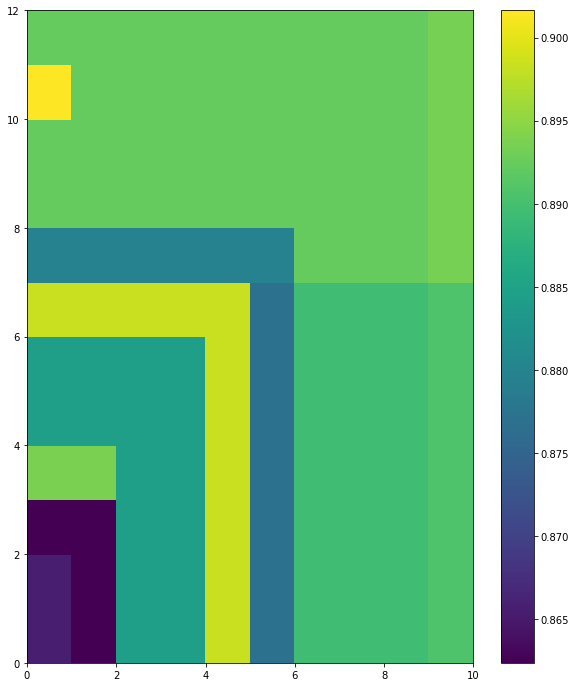

In [13]:
print('len radius:', len(ms_radius))
print('len btwdist:', len(ms_between_distances))

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)
#ax.matshow(IMG)

heatmap = ax.pcolor(IMG)
cbar = plt.colorbar(heatmap)

plt.show()